In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# from dotenv import load_dotenv, find_dotenv
import os
from datetime import date, timedelta
import plotly.express as px

pd.set_option("display.max_columns", None)


In [2]:
# dotenv_path = find_dotenv()
# load_dotenv(dotenv_path)
# FACEIT_PLAYERID = os.environ.get("FACEIT_PLAYERID")
FACEIT_PLAYERID = "2fb9fe10-5c7e-4f2f-860b-a9ee2f88801a"

In [3]:
DF_all = pd.read_pickle("./AllDatabz2.pkl", compression="bz2")


In [4]:
Map_names = ['de_cache', 'de_cbble', 'de_dust2', 'de_inferno', 'de_mirage','de_nuke', 'de_overpass', 'de_train']

In [5]:
DF_all = DF_all[DF_all['Map'].isin(Map_names)]
DF_all["K/D"] = DF_all["Kills"] / DF_all["Deaths"]
DF_all["K/A"] = DF_all["Kills"] / DF_all["Assists"]
DF_all = DF_all.query("Rounds > 16")
DF_all = DF_all[~DF_all["K/D"].isin([np.inf, -np.inf, np.nan])]
DF_all = DF_all[~DF_all["K/A"].isin([np.inf, -np.inf, np.nan])]



In [6]:
def count_wins(x):
    wins = x.value_counts().get("Win")
    if wins:
        return wins
    else:
        return 0

In [7]:
q_low = DF_all["Kills"].quantile(0.01)
q_hi = DF_all["Kills"].quantile(0.99)

DF_all = DF_all[(DF_all["Kills"] < q_hi) & (DF_all["Kills"] > q_low)]

In [8]:
DF_me = DF_all.query("PlayerId == @FACEIT_PLAYERID")
DF_others:pd.DataFrame = DF_all.query("PlayerId != @FACEIT_PLAYERID")

In [9]:
DF_me["index"] = np.arange(len(DF_me))

C:\Users\local_ec22805\Temp\ipykernel_28720\2280133688.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  DF_me["index"] = np.arange(len(DF_me))


In [10]:
Maps_others = (
    DF_others.groupby(by="Map")
    .aggregate(
        {
            "Kills": "sum",
            "Deaths": "sum",
            "Mvps": "sum",
            "Map": "count",
            "Headshots%": "mean",
            "Result": lambda x: count_wins(x), 
        }
    )
    .rename({"Map": "TimesPlayed"}, axis=1)
)

Maps_me = (
    DF_me.groupby(by="Map")
    .aggregate(
        {
            "Kills": "sum",
            "Deaths": "sum",
            "Mvps": "sum",
            "Map": "count",
            "Headshots%": "mean",
            "Result": lambda x: count_wins(x), 
        }
    )
    .rename({"Map": "TimesPlayed"}, axis=1)
)


In [11]:
data = Maps_others.sort_values(by = "TimesPlayed")

fig = px.bar(data, y="TimesPlayed", x=data.index,
            text_auto = ".2s",
            title="Most played maps for other players from Faceit"
            )
fig.update_layout(xaxis_tickangle=-30)

fig.show()

In [12]:
data = Maps_me.sort_values(by = "TimesPlayed")

fig = px.bar(data, y="TimesPlayed", x=data.index,
            text_auto = ".2s",
            title="My most played maps"
            )
fig.update_layout(xaxis_tickangle=-30)

fig.show()

In [13]:
Maps_others["WinRate%"] = (Maps_others["Result"] / Maps_others["TimesPlayed"] * 100).astype(int)
Maps_others["K/D"] = round(Maps_others["Kills"] / Maps_others["Deaths"], 2)
Maps_others.sort_values(by="TimesPlayed", inplace=True, ascending=False)
Maps_others["WinRateDiff"] = Maps_others["WinRate%"] - 50 


Maps_me["WinRate%"] = (Maps_me["Result"] / Maps_me["TimesPlayed"] * 100).astype(int)
Maps_me["K/D"] = round(Maps_me["Kills"] / Maps_me["Deaths"], 2)
Maps_me.sort_values(by="TimesPlayed", inplace=True, ascending=False)
Maps_me["WinRateDiff"] = Maps_me["WinRate%"] - 50 



In [14]:
def human_format(num):
    num = float('{:.3g}'.format(num))
    magnitude = 0
    while abs(num) >= 1000:
        magnitude += 1
        num /= 1000.0
    return '{}{}'.format('{:f}'.format(num).rstrip('0').rstrip('.'), ['', 'K', 'M', 'B', 'T'][magnitude])

In [15]:
data = Maps_others.sort_values(by = "WinRate%")

fig = px.bar(data, y="WinRate%", x=data.index,
            text=data["TimesPlayed"].apply(human_format),
            # text_auto = ".2f",
            title="Maps by win rate - others"
            )
fig.update_layout(xaxis_tickangle=-30)

fig.show()

In [16]:
data = Maps_me.sort_values(by = "WinRate%")

fig = px.bar(data, y="WinRate%", x=data.index,
            text=data["TimesPlayed"].apply(human_format),
            # text_auto = ".2f",
            title="Maps by win rate - me",
            
            
            
            )
fig.update_layout(xaxis_tickangle=-30)

fig.show()

In [17]:
def heatmap(data, title=""):
    corr = data.corr()
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(corr, cmap="coolwarm", vmin=-1, vmax=1)
    fig.colorbar(cax)
    ticks = np.arange(0, len(corr.columns), 1)
    ax.set_xticks(ticks)
    plt.xticks(rotation=45)
    ax.set_yticks(ticks)
    ax.set_xticklabels(corr.columns)
    ax.set_yticklabels(corr.columns)

    matrix = pd.DataFrame(data.corr(method="pearson")).round(2)
    for i in range(len(matrix)):
        for j in range(len(matrix.iloc[0])):
            text = ax.text(j, i, matrix.iloc[i, j], ha="center", va="center", color="w")
    ax.set_title(title, pad=20)


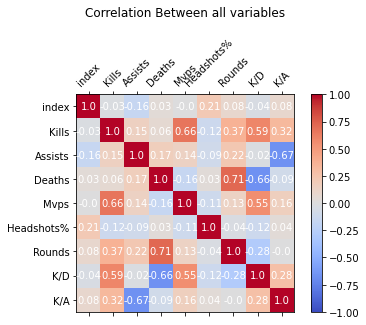

In [18]:
heatmap(
    DF_me.select_dtypes("number").drop(columns = ["Year", "Month", "Day", "DateOrdinal"]),
    title="Correlation Between all variables",
)
# there is a correlation between installs and rating count -> more people installs leads to more people commenting
# next to no correlaiton between everything


In [19]:
Maps_all = DF_all.groupby(by=["PlayerId", "Map"]).aggregate(
    {
        "Kills": "mean",
        "Assists": "mean",
        "Deaths": "mean",
        "Mvps": "mean",
        "Headshots%": "mean",
        "Map": "count",
        "Result": lambda x: count_wins(x),
    }
).rename({"Map": "TimesPlayed", "Result": "TimesWon"}, axis=1)#.reset_index()


In [20]:
Maps_all.head()

Kills   Assists  \
PlayerId                             Map                               
003185fd-320b-4563-b428-9adb0b2d4762 de_cache    20.545455  3.181818   
                                     de_cbble    27.500000  3.500000   
                                     de_dust2    18.750000  3.750000   
                                     de_inferno  20.294118  4.764706   
                                     de_mirage   19.947368  3.736842   

                                                    Deaths      Mvps  \
PlayerId                             Map                               
003185fd-320b-4563-b428-9adb0b2d4762 de_cache    19.363636  3.181818   
                                     de_cbble    17.000000  3.500000   
                                     de_dust2    16.625000  3.000000   
                                     de_inferno  18.588235  2.764706   
                                     de_mirage   20.894737  2.526316   

                                                 Headshots%  TimesPlayed  \
PlayerId                             Map                                   
003185fd-320b-4563-b428-9adb0b2d4762 de_cache     45.000000           11   
                                     de_cbble     32.000000            2   
                                     de_dust2     34.625000            8   
                                     de_inferno   50.764706           17   
                                     de_mirage    50.736842           19   

                                                 TimesWon  
PlayerId                             Map                   
003185fd-320b-4563-b428-9adb0b2d4762 de_cache           5  
                                     de_cbble           1  
                                     de_dust2           3  
                                     de_inferno        11  
                                     de_mirage          5

In [21]:
Maps_all = Maps_all.query("TimesWon > 10")#.reset_index()

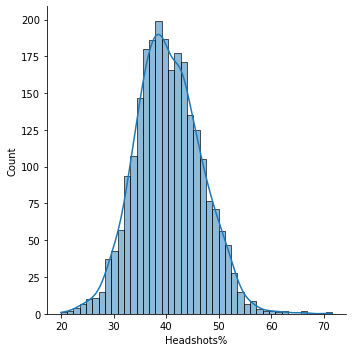

In [22]:
sns.displot(data = Maps_all, x = "Headshots%", kde = True)

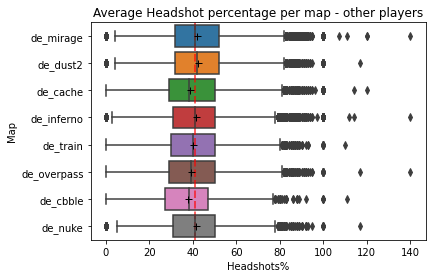

In [23]:
avg = DF_all["Headshots%"].mean()
g = sns.boxplot(
    data=DF_all,
    x="Headshots%",
    y="Map",
    showmeans = True,
    meanprops={"marker": "+", "markeredgecolor": "black", "markersize": "7"},
)
# for ax in g.axes.flat:
g.axvline(x=avg, color="red", alpha = .8, dashes=(5, 2))
plt.title("Average Headshot percentage per map - other players")
plt.show()

Text(0.5, 1.0, 'Average Headshot percentage per map - me')

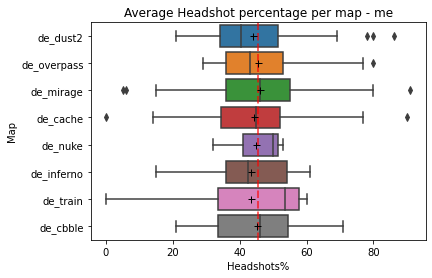

In [24]:
avg = DF_me["Headshots%"].mean()
g = sns.boxplot(
    data=DF_me,
    x="Headshots%",
    y="Map",
    showmeans = True,
    meanprops={"marker": "+", "markeredgecolor": "black", "markersize": "7"},
)
# for ax in g.axes.flat:
g.axvline(x=avg, color="red", alpha = .8, dashes=(5, 2))
plt.title("Average Headshot percentage per map - me")

In [25]:
All_players = DF_all.groupby(by=["PlayerId"]).aggregate(
    {
        "Kills": "sum",
        "Assists": "sum",
        "Deaths": "sum",
        "Mvps": "sum",
        "Headshots%": "mean",
        "Map": "count",
        "Rounds": "sum",
        "Result": lambda x: count_wins(x),
    }
).rename({"Map": "TimesPlayed", "Result": "TimesWon"}, axis=1)#.reset_index()

All_players["K/D"] = All_players["Kills"] / All_players["Deaths"]
All_players["K/A"] = All_players["Kills"] / All_players["Assists"]

All_players["K/R"] = All_players["Kills"] / All_players["Rounds"]
All_players["A/R"] = All_players["Assists"] / All_players["Rounds"]
All_players["D/R"] = All_players["Deaths"] / All_players["Rounds"]

All_players["K/G"] = All_players["Kills"] / All_players["TimesPlayed"]
All_players["D/G"] = All_players["Deaths"] / All_players["TimesPlayed"]
All_players["A/G"] = All_players["Assists"] / All_players["TimesPlayed"]


In [26]:
# All_players = pd.concat([All_players, Me_overall])

In [27]:
All_players["Me"] = All_players.index == FACEIT_PLAYERID

In [28]:
All_players

,Kills,Assists,Deaths,Mvps,Headshots%,TimesPlayed,Rounds,TimesWon,K/D,K/A,K/R,A/R,D/R,K/G,D/G,A/G,Me
PlayerId,,,,,,,,,,,,,,,,,
003185fd-320b-4563-b428-9adb0b2d4762,1501,284,1359,215,45.465753,73,1867,37,1.104489,5.285211,0.803964,0.152116,0.727906,20.561644,18.616438,3.890411,False
00390c8f-4529-43f0-9299-82d2d83e5cef,32161,6405,36037,4285,51.670000,1800,49196,930,0.892444,5.021233,0.653732,0.130194,0.732519,17.867222,20.020556,3.558333,False
0056abd1-95e2-472d-8894-0be2e302e1e5,65799,13060,66374,9713,45.962489,3439,91445,1748,0.991337,5.038208,0.719547,0.142818,0.725835,19.133178,19.300378,3.797616,False
00766b63-e51e-4410-8dde-43978d086c28,3435,835,3185,525,35.578125,192,4586,89,1.078493,4.113772,0.749019,0.182076,0.694505,17.890625,16.588542,4.348958,False
007b4abc-c18b-47e2-86ad-443c5844b6f1,850,153,715,131,32.300000,40,1112,21,1.188811,5.555556,0.764388,0.137590,0.642986,21.250000,17.875000,3.825000,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
fef7e5de-d8c5-4383-8246-6e39e89e0dc3,419,108,638,51,34.516129,31,839,14,0.656740,3.879630,0.499404,0.128725,0.760429,13.516129,20.580645,3.483871,False
ff33d143-524a-4d3b-af1a-f96c6c6073cb,15925,3259,15755,2130,40.514828,843,22025,453,1.010790,4.886468,0.723042,0.147968,0.715323,18.890866,18.689205,3.865955,False
ff6d37a3-b8c3-44c5-a3a8-cf4b25f3c870,2215,527,2450,283,40.911765,136,3521,68,0.904082,4.203036,0.629083,0.149673,0.695825,16.286765,18.014706,3.875000,False


In [29]:
All_players.query("Me == True")

,Kills,Assists,Deaths,Mvps,Headshots%,TimesPlayed,Rounds,TimesWon,K/D,K/A,K/R,A/R,D/R,K/G,D/G,A/G,Me
PlayerId,,,,,,,,,,,,,,,,,
2fb9fe10-5c7e-4f2f-860b-a9ee2f88801a,14956,3700,14196,2024,45.509709,824,20941,403,1.053536,4.042162,0.714197,0.176687,0.677905,18.150485,17.228155,4.490291,True


In [30]:
def abline(slope, intercept):
    axes = plt.gca()
    x_vals = np.array(axes.get_xlim())
    y_vals = intercept + slope * x_vals
    plt.plot(x_vals, y_vals, '--')
    
#https://www.statology.org/matplotlib-abline/

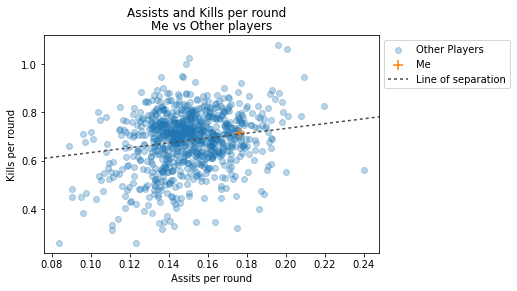

In [31]:
fig, ax = plt.subplots()
ax.scatter(All_players.query("Me != True")["A/R"], All_players.query("Me != True")["K/R"], alpha = 0.3, label = "Other Players")
ax.scatter(All_players.query("Me == True")["A/R"], All_players.query("Me == True")["K/R"], marker = "+", s = 100, label = "Me", alpha = 1)
ax.axline((All_players["A/R"].mean(), All_players["K/R"].mean()), slope = 1, color=".3", dashes=(2, 2), label = "Line of separation")
plt.xlabel("Assits per round")
plt.ylabel("Kills per round")
plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
plt.suptitle("Assists and Kills per round")
plt.title("Me vs Other players")
plt.show()


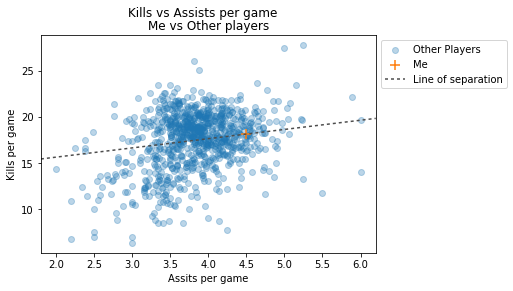

In [32]:
fig, ax = plt.subplots()
ax.scatter(All_players.query("Me != True")["A/G"], All_players.query("Me != True")["K/G"], alpha = 0.3, label = "Other Players")
ax.scatter(All_players.query("Me == True")["A/G"], All_players.query("Me == True")["K/G"], marker = "+", s = 100, label = "Me", alpha = 1)
ax.axline((All_players["A/G"].mean(), All_players["K/G"].mean()), slope = 1, color=".3", dashes=(2, 2), label = "Line of separation")
plt.xlabel("Assits per game")
plt.ylabel("Kills per game")
plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
plt.suptitle("Kills vs Assists per game")
plt.title("Me vs Other players")
plt.show()


In [33]:
All_players.query("Me == True")

,Kills,Assists,Deaths,Mvps,Headshots%,TimesPlayed,Rounds,TimesWon,K/D,K/A,K/R,A/R,D/R,K/G,D/G,A/G,Me
PlayerId,,,,,,,,,,,,,,,,,
2fb9fe10-5c7e-4f2f-860b-a9ee2f88801a,14956,3700,14196,2024,45.509709,824,20941,403,1.053536,4.042162,0.714197,0.176687,0.677905,18.150485,17.228155,4.490291,True


In [42]:
# All_players["Better"]
All_players["HaveBetterK/G"] = All_players["K/G"] > 18.150485
All_players["HaveBetterA/G"] = All_players["A/G"] > 4.490291

All_players["BetterGameRatio"] = All_players["HaveBetterK/G"] & All_players["HaveBetterA/G"]


In [35]:
All_players["BetterGameRatio"].value_counts() # check with gabe

False    819
True      45
Name: BetterGameRatio, dtype: int64

In [36]:
print(round(len(All_players[All_players["K/R"] > 0.714197]) / 864 * 100, 2))# above
print(round(len(All_players[All_players["K/R"] < 0.714197]) / 864 * 100, 2)) # below

43.75
56.25


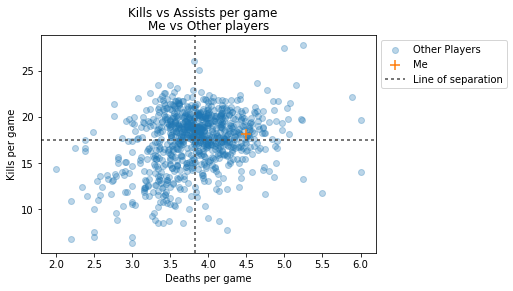

In [43]:
fig, ax = plt.subplots()
ax.scatter(
    All_players.query("Me != True")["A/G"],
    All_players.query("Me != True")["K/G"],
    alpha=0.3,
    label="Other Players",
)
ax.scatter(
    All_players.query("Me == True")["A/G"],
    All_players.query("Me == True")["K/G"],
    marker="+",
    s=100,
    label="Me",
    alpha=1,
)


ax.axhline(
    All_players["K/G"].mean(),
    color=".3",
    dashes=(2, 2),
    label="Line of separation",
)

ax.axvline(
    All_players["A/G"].mean(),
    color=".3",
    dashes=(2, 2),
)

plt.xlabel("Deaths per game")
plt.ylabel("Kills per game")
plt.legend(bbox_to_anchor=(1, 1), loc="upper left")
plt.suptitle("Kills vs Assists per game")
plt.title("Me vs Other players")
plt.show()

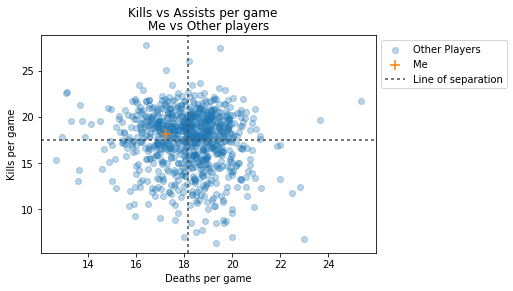

In [41]:
fig, ax = plt.subplots()
ax.scatter(
    All_players.query("Me != True")["D/G"],
    All_players.query("Me != True")["K/G"],
    alpha=0.3,
    label="Other Players",
)
ax.scatter(
    All_players.query("Me == True")["D/G"],
    All_players.query("Me == True")["K/G"],
    marker="+",
    s=100,
    label="Me",
    alpha=1,
)


ax.axhline(
    All_players["K/G"].mean(),
    color=".3",
    dashes=(2, 2),
    label="Line of separation",
)

ax.axvline(
    All_players["D/G"].mean(),
    color=".3",
    dashes=(2, 2),
)

plt.xlabel("Deaths per game")
plt.ylabel("Kills per game")
plt.legend(bbox_to_anchor=(1, 1), loc="upper left")
plt.suptitle("Kills vs Assists per game")
plt.title("Me vs Other players")
plt.show()

In [ ]:
# All_players[All_players["D/G"] < All_players["D/G"].quantile(0.5)]


In [ ]:
x = All_players[All_players["D/G"] <= All_players["D/G"].mean()]["D/G"].sort_values()
y1 = np.full(len(x), 30).tolist()
y2 =  x - All_players["D/G"].mean() + All_players["K/G"].mean()

In [ ]:
# All_players["D/G"]+ All_players["K/G"]

In [ ]:
y2 #= np.linspace(y2.min(), y2.max(), len(x))

PlayerId
7d11b8fe-d84c-40c2-b405-3bfd2d4a5aa6    11.975191
c745c457-e2f5-47c4-a1c8-d47729cb4ab2    12.209282
bab81189-a751-4c73-928b-5a30eac3963e    12.377114
277c05b2-6bdf-4fb7-bcad-ec6ac2239cf1    12.426334
83323d68-4713-4e42-90e6-66dd329ccad6    12.607883
                                          ...    
0c105a1e-10b2-4ee8-80b6-f8d32caab751    17.437596
38bcbf1f-2fb9-4eec-924f-ef322bbc8df1    17.438653
9d661395-e375-4637-b6a3-22e06223bcaf    17.443048
fbde9814-5bca-4fb7-9639-4254199ecfef    17.445803
31d54b39-7210-4752-8e13-8dc06e032106    17.451706
Name: D/G, Length: 401, dtype: float64

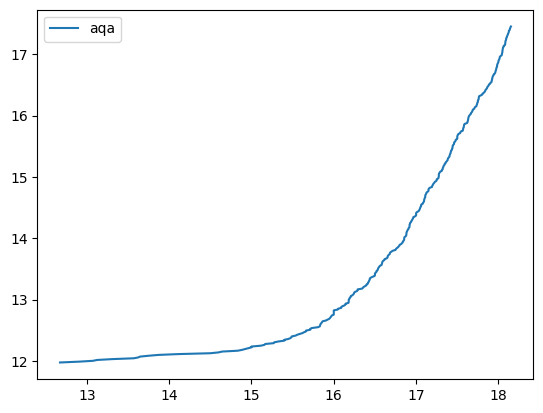

In [ ]:
fig, ax = plt.subplots()
# x = np.linspace(12, 18, len(x))
# ax.plot(x, y1)
ax.plot(x, y2, label = "aqa")
# ax.fill_between(x, y1, y2, interpolate=True, alpha = .3)
plt.legend()


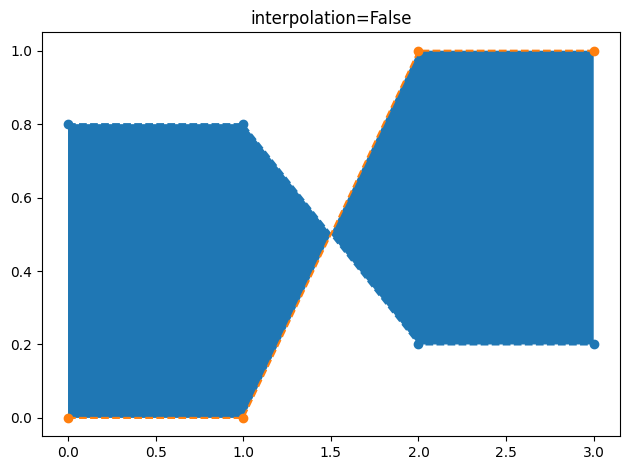

In [ ]:
x = np.array([0, 1, 2, 3]).tolist()
y1 = np.array([0.8, 0.8, 0.2, 0.2]).tolist()
y2 = np.array([0, 0, 1, 1])

fig, ax1 = plt.subplots()

ax1.set_title('interpolation=False')
ax1.plot(x, y1, 'o--')
ax1.plot(x, y2, 'o--')
ax1.fill_between(x, y1, y2)
# ax1.fill_between(x, y1, y2, where=(y1 < y2), color='C1', alpha=0.3)


fig.tight_layout()


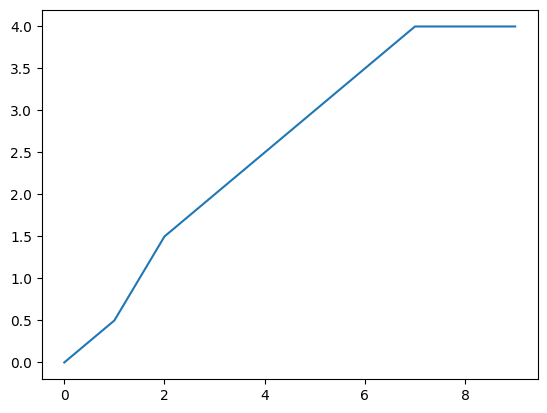

In [ ]:
a_seq = [0.,0.5, 1.5 ,2.,  2.5, 3.,  3.5, 4.,  4.,  4. ]
l1 = [0.0, 0.0, 1.0, 1.0, 1.0, 2.0, 3.0, 4.0, 4.0, 4.0]
l2 = [0.0, 1.0, 2.0, 3.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0]
plt.plot(np.arange(0,len(a_seq)),a_seq, label = "a_seq")
# plt.plot(l1)
# plt.plot(l2)
# plt.fill_between( np.arange(0,len(l1)), l2, l1, alpha=0.2)
# plt.legend()
# plt.show()